# Classification

In [1]:
#!usr/bin/env python3

# Basic import
import numpy as np
import matplotlib.pyplot as plt

# Pytorch import
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset
from torchvision import transforms, datasets
import torch.nn.functional as F

# Import models and training functions
from models import ConvNet, FFNet
from training import train_epoch, val_epoch
from functions import my_accuracy

# Import progress bars
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from time import sleep

#Import sys
import sys





## Dataset and Dataloader

In [2]:
### Dataset

dataset = datasets.MNIST('MNIST', train = True, download = True,
                             transform = transforms.Compose([
                               transforms.ToTensor()
                             ]))

test_data = datasets.MNIST('MNIST', train = False, download = True,
                             transform=transforms.Compose([
                               transforms.ToTensor()
                             ]))

# Divide data dataset in train dataset and val dataset
train_data, val_data = torch.utils.data.random_split(dataset, [50000, 10000])

In [3]:
### Dataloaders
train_dataloader = DataLoader(train_data, batch_size = 100, shuffle = True, num_workers=0)
val_dataloader = DataLoader(val_data, batch_size = 100, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size = 1, shuffle=True, num_workers=0)

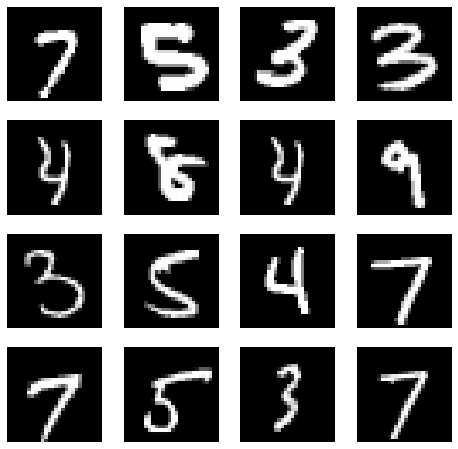

In [4]:
# Plot Mnist
figure = plt.figure(figsize=(8, 8))
cols, rows = 4,4


for i in range(1,cols * rows+1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Define the network

In [5]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


In [13]:
# Define the pytorch_lightning networks
parameters1 = {
    "act" : nn.ReLU, 
    "optimizer" : optim.Adam, 
    "loss_fn" : nn.CrossEntropyLoss(),
    "lr" : 0.001, 
    "weight_decay" : 0.0, 
    "drop_p" : 0.1,
    "momentum" : 0.0
}

parameters2 = {
    "act" : "ReLU", 
    "optimizer" : "RMSprop", 
    "loss_fn" : "CrossEntropyLoss",
    "lr" : 0.001, 
    "weight_decay" : 0.0, 
    "drop_p" : 0.1,
    "momentum" : 0.0,
}

parameters3 = {
    "act" : "ReLU", 
    "optimizer" : "SGD", 
    "loss_fn" : "CrossEntropyLoss",
    "lr" : 0.001, 
    "weight_decay" : 0.0, 
    "drop_p" : 0.1,
    "momentum" : 0.0,
}


# Set parameters used
parameters = parameters1

# Inizialize the network
torch.manual_seed(0)
net = ConvNet(parameters)
net.to(device)

Network initialized


ConvNet(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.1, inplace=False)
  )
  (lin): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

## Training

In [14]:
# Define the loss function
loss_function = parameters["loss_fn"]

# Define the optimizer
optimizer = parameters["optimizer"](net.parameters(), lr = parameters["lr"], weight_decay = parameters["weight_decay"])


In [15]:
### Training epochs

def train_epochs(max_num_epochs, early_stopping = True):
    
    # Pogress bar
    pbar = tqdm_notebook(range(max_num_epochs))

    # Inizialize empty lists to save losses
    train_loss_log = []
    val_loss_log = []
    accuracy = []

    for epoch_num in pbar:
        # Compute accuracy before training
        mismatched, confusion, acc = my_accuracy(net, device, test_dataloader)

        # Tran epoch
        mean_train_loss = train_epoch(net, device, train_dataloader, loss_function, optimizer)

        # Validate epoch
        mean_val_loss = val_epoch(net,  device, val_dataloader, loss_function)

        # Append losses and accuracy
        train_loss_log.append(mean_train_loss)
        val_loss_log.append(mean_val_loss)
        accuracy.append(acc)

        # Set pbar description
        pbar.set_description("Train loss: %s" %round(mean_train_loss,2)+", "+"Val loss %s" %round(mean_val_loss,2)
                             +", "+"Test accuracy %s" %round(acc,2)+"%")
        
        # Early stopping
        if early_stopping:
            if np.mean(val_loss_log[-5:]) < val_loss_log[-1]:
                print("Training stopped at epoch "+str(epoch_num)+" to avoid overfitting.")
                break
    
    return train_loss_log, val_loss_log, accuracy
    

In [16]:
# Training
max_num_epochs = 50
train_loss_log, val_loss_log, accuracy = train_epochs(max_num_epochs)

  0%|          | 0/50 [00:00<?, ?it/s]

Training stopped at epoch 7 to avoid overfitting.


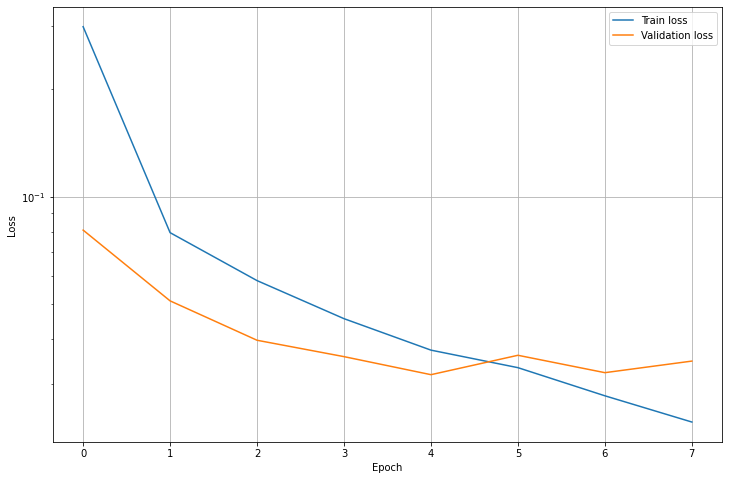

In [18]:
### Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## Save and load model

In [19]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net.state_dict(),
            "parameters" : parameters}
# Save the state dict to a file
torch.save(net_dict,'ConvNet_parameters.torch')


In [20]:
### Reload the network state

# Load the state dict previously saved
net_dict = torch.load('ConvNet_parameters.torch')
net_state_dict = net_dict["state"]
net_parameters_dict = net_dict["parameters"]

# Redefine the network and upload parameters
net = ConvNet(net_parameters_dict)
net.load_state_dict(net_state_dict)

Network initialized


<All keys matched successfully>

# Network analysis

## Accuracy
    
    

In [21]:
### Compute accuracy of the model
mismatched, confusion, acc = my_accuracy(net, device, test_dataloader)
print("Test accuracy: ", acc, "%")

Test accuracy:  99.17 %


### Plot mismatched numbers


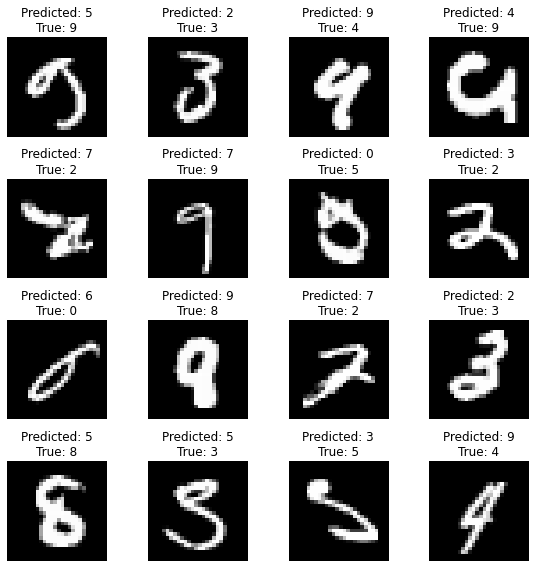

In [22]:
# Plot Mismatched numbers
figure = plt.figure(figsize=(8, 8))
cols, rows = 4,4


for i in range(rows*cols):
    img = mismatched[i][0]
    
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray"  )
    plt.title("Predicted: "+str(mismatched[i][1])+"\n"+"True: "+str(mismatched[i][2]))
    
plt.tight_layout()
plt.show()

### Confusion matrix

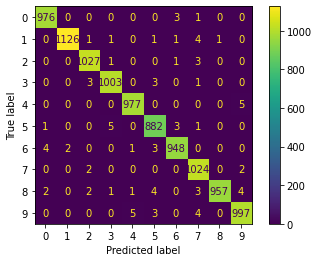

In [23]:
### Build the confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

# Get predictions and ground trues
trues = confusion[0]
predictions = confusion[1]

# Compute and plot confusion matrix
cm = confusion_matrix(trues, predictions, labels =np.array(range(10)) )
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = np.array(range(10)))
disp.plot()
plt.show()


## Network parameters 

In [24]:
# Access convolution network parameters

dense_weight = net.lin[0].weight.data.cpu().numpy()
dense_bias = net.lin[0].bias.data.cpu().numpy()
out_weight = net.lin[3].weight.data.cpu().numpy()
out_bias = net.lin[3].bias.data.cpu().numpy()

### Convolution filtered images

In [25]:
# Acces convolution filters
conv1 = net.cnn[0].weight.data.cpu()
conv2 = net.cnn[4].weight.data.cpu()

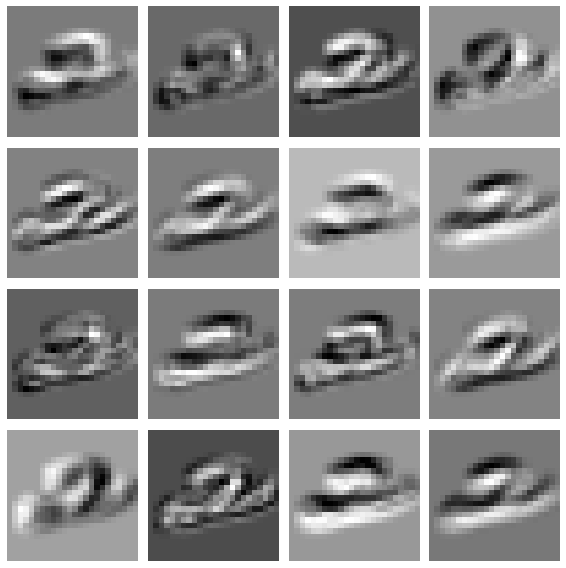

In [26]:
### First convolution filter
fig = plt.figure(figsize=(8, 8))
cols, rows = 4,4

# Take an image and apply convolution
img, label = train_data[0]
img = F.conv2d(img.unsqueeze(dim=0), conv1)

# Plot filtered images

for i in range(16):
    fig.add_subplot(rows, cols, i+1)
    plt.axis("off")
    #plt.title("Filter %d" %(i+1))
    plt.imshow(img.squeeze().numpy()[i], cmap="gray")
    
plt.tight_layout()
plt.show()




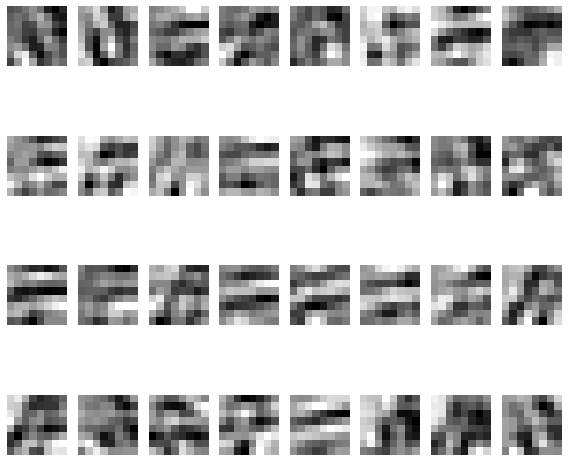

In [27]:
### Second convolution filter
fig = plt.figure(figsize=(8, 8))
cols, rows = 8,4

# Take an image and apply convolution
img, label = train_data[9]
img = F.conv2d(img.unsqueeze(dim=0), conv1)
img = F.relu(img)
img  = F.max_pool2d(img, kernel_size = 2)
img = F.conv2d(img, conv2)

# Plot filtered images

for i in range(32):
    fig.add_subplot(rows, cols, i+1)
    plt.axis("off")
    #plt.title("Filter %d" %(i+1))
    plt.imshow(img.squeeze().numpy()[i], cmap="gray")
    
plt.tight_layout()
plt.show()